## Install requirements

In [5]:
%pip install fiona shapely pyproj rtree geopandas pycountry matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 91.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 52.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Load dependencies

In [7]:
  # notebook dependencies
import ipywidgets as widgets
from IPython.display import display


# data handler libraries
import pandas as pd
import numpy as np
import geopandas as gp

# visualisation libraries
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# misc
from urllib.request import urlretrieve
import pycountry
import os

# initialize download url for the datasets
base_download_url = 'https://bbmaps.itu.int/geonetwork/srv/api/records/884b4f42-2d49-4622-b1d8-e6285bf46c7f/attachments/'

## Input parameters

In [8]:
#@title
# Define the layout for the input fields
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',  # Align items vertically in the middle
    justify_content='space-between'
)

item_layout2 = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1',
    display='flex',
    flex_flow='row wrap',
    align_items='center',  # Align items vertically in the middle
    justify_content='space-between'
)

# Create the input fields
country = widgets.Dropdown(
    description='Country:',
    options=list(map(lambda x: x.name, pycountry.countries)),
    value='Brazil',
    layout=item_layout2,
    style={'description_width': 'initial'}
)

municipality_code = widgets.Text(
    value='1504059',
    description='Municipaliy code:',
    layout=item_layout2,
    style={'description_width': 'initial'}
)

population_filename = widgets.Text(
    value='bra_ppp_2020_1km_Aggregated_UNadj_sampled.parquet',
    description='Population dataset filename:',
    layout=item_layout2,
    style={'description_width': 'initial'}
)

population_radius = widgets.IntSlider(
    description='Population radius (km):',
    min=0,
    max=6,
    step=1,
    value=5,
    layout=item_layout,
    style={'description_width': 'initial'}
)

# Create a container to hold the input fields
inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([country], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([municipality_code], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([population_filename], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([population_radius], layout=widgets.Layout(justify_content='space-between')),
        #widgets.HBox([max_tower_reach, n_visible], layout=widgets.Layout(justify_content='space-between'))
    ]
)

# Display the input fields
display(inputs_layout)


## Download & Initialize school data

In [9]:
def download_entity_dataset(base_url, entity_type, country_name, administrative_division_code):
  """
  Downloads a dataset for a specific entity type and location.

  Args:
      base_url (str): The base URL where the dataset files are stored.
      entity_type (str): The type of entity to download the dataset for.
      country_name (str): The name of the country where the entity is located.
      administrative_division_code (str): The administrative division code for the entity.

  Returns:
      str: The filename of the downloaded dataset.

  Raises:
      pycountry.LookupError: If the country name is not recognized.

  """
  # Get the country code from the country name
  country_code = pycountry.countries.get(name = country.value).alpha_3

  # Construct the filename for the dataset
  entity_filename = f'{country_code.lower()}_{administrative_division_code}_{entity_type}.parquet'

  # Download the dataset file
  urlretrieve(base_url + entity_filename, entity_filename)

  # Return the filename of the downloaded dataset
  return entity_filename


def download_from_filename(base_url, filename):

  """
  Downloads a dataset for a specific filename.

  Args:
      base_url (str): The base URL where the dataset files are stored.
      filename (str): The name of the file.

  Returns:
      str: The filename of the downloaded dataset.

  """

  # Download the dataset file
  urlretrieve(base_url + filename, filename)

  # Return the filename of the downloaded dataset
  return filename


# Reading school data from a file into a python data table
def read_file(file_path):
    """
    Read a file from the path.

    Args:
        file_path (str): The path of the file to read.

    Returns:
        pd.DataFrame or gp.GeoDataFrame: The data read from the file.
    """
    suffix = os.path.splitext(file_path)[1]

    assert os.path.exists(file_path), f'{file_path} cannot be found in the data directory!'

    if suffix == '.csv':
        return pd.read_csv(file_path)
    elif suffix == '.xlsx' or suffix == '.xls':
        return pd.read_excel(file_path, engine = 'openpyxl')
    elif suffix == '.shp' or suffix == '.zip':
        return gp.read_file(file_path)
    elif suffix == '.parquet':
        try:
          return gp.read_parquet(file_path)
        except:
          return pd.read_parquet(file_path)
    elif suffix == '.geoparquet':
        return gp.read_parquet(file_path)
    elif suffix == '.json':
        return pd.read_json(file_path)
    elif suffix == '.geojson':
        return gp.read_file(file_path)
    elif suffix == '.gpkg':
        return gp.read_file(file_path)
    else:
        raise ValueError(f"Unsupported file type: {suffix}")


In [10]:
file_name_school = download_entity_dataset(base_download_url, 'school', country.value, municipality_code.value)

In [12]:
df_school = read_file(file_name_school)
#data_table.DataTable(df_school, num_rows_per_page=10)
df_school.head(10)

,lat,lon,label,geometry
source_id,,,,
15092518,-2.006472,-47.454827,unconnected_school,POINT (-47.45483 -2.00647)
15092526,-2.042973,-47.557938,connected_school,POINT (-47.55794 -2.04297)
15092534,-1.915732,-47.520132,connected_school,POINT (-47.52013 -1.91573)
15092542,-2.040823,-47.558717,connected_school,POINT (-47.55872 -2.04082)
15092577,-2.042782,-47.551758,connected_school,POINT (-47.55176 -2.04278)
15092585,-2.045535,-47.551423,connected_school,POINT (-47.55142 -2.04554)
15092593,-2.040445,-47.563479,connected_school,POINT (-47.56348 -2.04045)
15092640,-1.903420,-47.485589,unconnected_school,POINT (-47.48559 -1.90342)
15092690,-1.891456,-47.477476,unconnected_school,POINT (-47.47748 -1.89146)


## Download & Initialize population dataset

In [13]:
file_name_population = download_from_filename(base_download_url, population_filename.value)

In [14]:
df_pop = gp.read_parquet(file_name_population)
#data_table.DataTable(df_pop, num_rows_per_page=3)
df_pop.head(10)

,lon,lat,population,geometry,area_pop_tile
1104934,-47.447083,-2.079583,17.845469,"POLYGON ((-5281285.136 -229499.578, -5281285.1...",1.0
1104935,-47.438750,-2.079583,39.662052,"POLYGON ((-5280357.474 -229499.578, -5280357.4...",1.0
1094193,-47.572083,-2.046250,285.524780,"POLYGON ((-5295200.072 -225811.346, -5295200.0...",1.0
1094194,-47.563750,-2.046250,3270.182861,"POLYGON ((-5294272.410 -225811.346, -5294272.4...",1.0
1094195,-47.555416,-2.046250,4223.625000,"POLYGON ((-5293344.748 -225811.346, -5293344.7...",1.0
1094196,-47.547083,-2.046250,2352.512207,"POLYGON ((-5292417.085 -225811.346, -5292417.0...",1.0
1094197,-47.538750,-2.046250,1977.155518,"POLYGON ((-5291489.423 -225811.346, -5291489.4...",1.0
1094198,-47.530416,-2.046250,240.957535,"POLYGON ((-5290561.760 -225811.346, -5290561.7...",1.0
1055801,-47.438750,-1.929583,4.695161,"POLYGON ((-5280357.474 -212903.139, -5280357.4...",1.0
1055802,-47.430416,-1.929583,4.339626,"POLYGON ((-5279429.811 -212903.139, -5279429.8...",1.0


### Check population data projection

In [15]:
df_pop.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Define school area and overlay the population data

In [16]:
# Transform school dataset to World Mercator crs
df_school_merc = df_school.to_crs('epsg:3395')

# Define polygon around school point using population radius parameter
radius_ = population_radius.value * 1000 # transform from kilometers to meters
df_school_merc = df_school_merc.buffer(radius_).reset_index()

# Performing overlay funcion and join the larger tile
gdf_overlayed = df_pop.reset_index().overlay(df_school_merc, how='intersection')

# Calculating the areas of the newly-created geometries - i.e. how much of the larger tile that is in the WorldPop tile
gdf_overlayed['area_joined'] = gdf_overlayed.area / 10**6

# Calculating the estimated population inside the larger tile
gdf_overlayed[f'pop_{population_radius.value}km'] = (gdf_overlayed['area_joined'] / gdf_overlayed['area_pop_tile']) * gdf_overlayed['population']

In [17]:
gdf_overlayed.head(15)

,index,lon,lat,population,area_pop_tile,source_id,geometry,area_joined,pop_5km
0,1104934,-47.447083,-2.079583,17.845469,1.0,15092852,"POLYGON ((-5281285.136 -230499.578, -5282285.1...",1.000000,17.845469
1,1104934,-47.447083,-2.079583,17.845469,1.0,15536700,"POLYGON ((-5281285.136 -230499.578, -5282285.1...",1.000000,17.845469
2,1104934,-47.447083,-2.079583,17.845469,1.0,15552691,"POLYGON ((-5281285.136 -230499.578, -5282285.1...",1.000000,17.845469
3,1104935,-47.438750,-2.079583,39.662052,1.0,15092852,"POLYGON ((-5280357.474 -230499.578, -5281357.4...",1.000000,39.662052
4,1104935,-47.438750,-2.079583,39.662052,1.0,15536700,"POLYGON ((-5280357.474 -230499.578, -5281357.4...",1.000000,39.662052
5,1104935,-47.438750,-2.079583,39.662052,1.0,15552691,"POLYGON ((-5280357.474 -230313.301, -5280708.3...",0.949303,37.651289
6,1094193,-47.572083,-2.046250,285.524780,1.0,15092526,"POLYGON ((-5295200.072 -226811.346, -5296200.0...",1.000000,285.524780
7,1094193,-47.572083,-2.046250,285.524780,1.0,15092542,"POLYGON ((-5295200.072 -226811.346, -5296200.0...",1.000000,285.524780
8,1094193,-47.572083,-2.046250,285.524780,1.0,15092577,"POLYGON ((-5295200.072 -226811.346, -5296200.0...",1.000000,285.524780
9,1094193,-47.572083,-2.046250,285.524780,1.0,15092585,"POLYGON ((-5295200.072 -226811.346, -5296200.0...",1.000000,285.524780


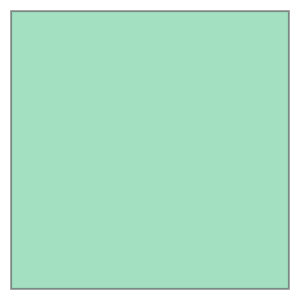

In [18]:
gdf_overlayed.loc[14, 'geometry']

(-5296169.023744846,
 -5286118.033660087,
 -227565.46425860337,
 -217034.4236406179)

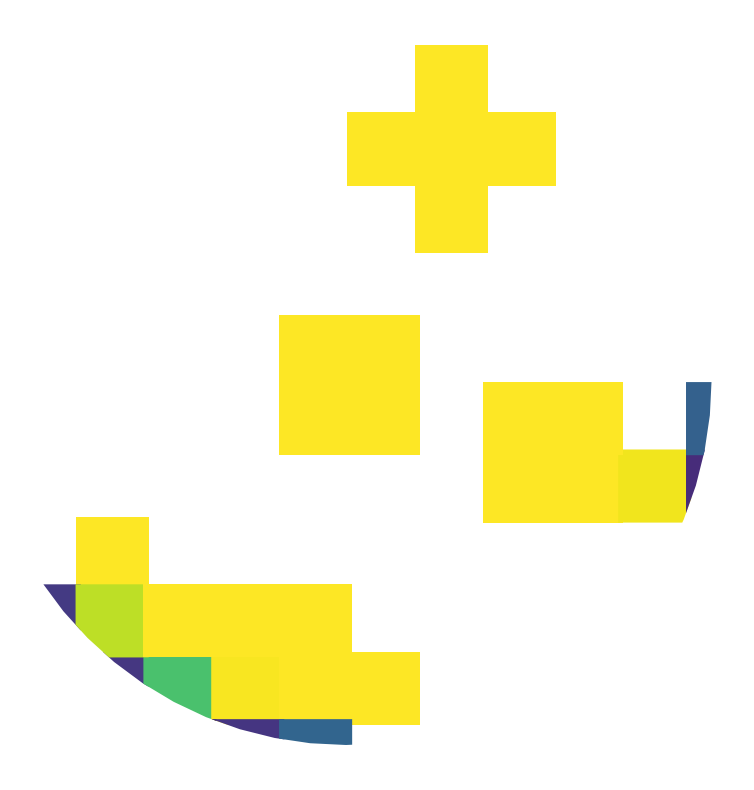

In [19]:
fig, ax =plt.subplots(1, figsize = (10,10))
gdf_overlayed.loc[gdf_overlayed.source_id == 15547116].plot(column= 'area_joined',ax=ax)
ax.axis('off')

## Aggregate population raster values

In [20]:
df_school = df_school.join(gdf_overlayed.groupby('source_id').sum(numeric_only=True)[f'pop_{population_radius.value}km'])


In [22]:
#data_table.DataTable(df_school, num_rows_per_page=10)
df_school.head(10)

,lat,lon,label,geometry,pop_5km
source_id,,,,,
15092518,-2.006472,-47.454827,unconnected_school,POINT (-47.45483 -2.00647),997.645860
15092526,-2.042973,-47.557938,connected_school,POINT (-47.55794 -2.04297),24308.345270
15092534,-1.915732,-47.520132,connected_school,POINT (-47.52013 -1.91573),438.373291
15092542,-2.040823,-47.558717,connected_school,POINT (-47.55872 -2.04082),24309.514631
15092577,-2.042782,-47.551758,connected_school,POINT (-47.55176 -2.04278),24312.047974
15092585,-2.045535,-47.551423,connected_school,POINT (-47.55142 -2.04554),24310.118516
15092593,-2.040445,-47.563479,connected_school,POINT (-47.56348 -2.04045),24306.205338
15092640,-1.903420,-47.485589,unconnected_school,POINT (-47.48559 -1.90342),431.628073
15092690,-1.891456,-47.477476,unconnected_school,POINT (-47.47748 -1.89146),205.725371
